In [19]:
import mne
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [22]:

# Load your EDF file
edf_path = 'Mouse_3a_1hr_seg1213.edf'
raw = mne.io.read_raw_edf(edf_path, preload=True)

# Select EEG and EMG channels
picks = ['CHN9 - Eeg', 'CHN10 - Ecg']  # Adjust channel names as needed

# Extract data and convert to NumPy array
data, times = raw[picks, :]
data = data.transpose()  # Transpose to have shape (n_samples, n_channels)

# Standardize the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Define segmentation parameters
sampling_rate = 2000  # Sampling rate in Hz
segment_length = 10 * sampling_rate  # 10 seconds * 2000 Hz = 20,000 data points per segment

# Segment the data
segments = np.array([data[i:i + segment_length] for i in range(0, len(data) - segment_length + 1, segment_length)])


# Load the labels from the CSV file
labels_df = pd.read_csv('./Book.csv')
labels = labels_df['Stage'].values - 1

# Ensure the number of segments matches the number of labels
if len(segments) != len(labels):
    print("Mismatch between the number of segments and labels. Adjust the data or labels accordingly.")
else:
    print("Data and labels are ready for model training.")

# Split data into training, validation, and test sets
segments_train, segments_test, labels_train, labels_test = train_test_split(segments, labels, test_size=0.2, random_state=26)

# Define, compile, and train the model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, input_shape=(segment_length, 2), kernel_regularizer=l2(0.01)),
    MaxPooling1D(pool_size=2),
    
    Conv1D(filters=64, kernel_size=3),
    MaxPooling1D(pool_size=2),
    
    Flatten(),
    Dense(100, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.33),
    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=1, mode='min', restore_best_weights=True)

model.fit(segments_train, labels_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(segments_test, labels_test)
print(f"Test Accuracy: {test_acc}")



Extracting EDF parameters from /Users/eribertonurce/Desktop/project/python/mne/Mouse_3a_1hr_seg1213.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7199999  =      0.000 ...  3599.999 secs...
Data and labels are ready for model training.


/usr/local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 790ms/step - accuracy: 0.3449 - loss: 6.6498 - val_accuracy: 0.4483 - val_loss: 18.4503
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 778ms/step - accuracy: 0.5778 - loss: 5.9507 - val_accuracy: 0.5690 - val_loss: 41.7407
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.5130 - loss: 5.3259
Test Accuracy: 0.5416666865348816


In [4]:
learning_rates = [0.01, 0.001, 0.0001]  # Example learning rates

for lr in learning_rates:
    # Define the model architecture
    # Define, compile, and train the model with Batch Normalization
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, input_shape=(segment_length, 2)),
        BatchNormalization(),  # Add Batch Normalization
        Activation('relu'),    # Activation function applied after Batch Normalization
        MaxPooling1D(pool_size=2),
        
        Conv1D(filters=64, kernel_size=3),
        BatchNormalization(),  # Add Batch Normalization
        Activation('relu'),    # Activation function applied after Batch Normalization
        MaxPooling1D(pool_size=2),
        
        Flatten(),
        Dense(100, activation='relu'),
        Dropout(0.2),
        Dense(3, activation='softmax')
    ])
    
    # Compile the model with the current learning rate
    model.compile(optimizer=Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(segments_train, labels_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)  # Set verbose=0 to silence the output
    
    # Print out the accuracy of the model on the last epoch
    print(f"Learning Rate: {lr}, Last Epoch Accuracy: {history.history['accuracy'][-1]}")

Learning Rate: 0.01, Last Epoch Accuracy: 0.43913042545318604
Learning Rate: 0.001, Last Epoch Accuracy: 0.665217399597168
Learning Rate: 0.0001, Last Epoch Accuracy: 0.582608699798584


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


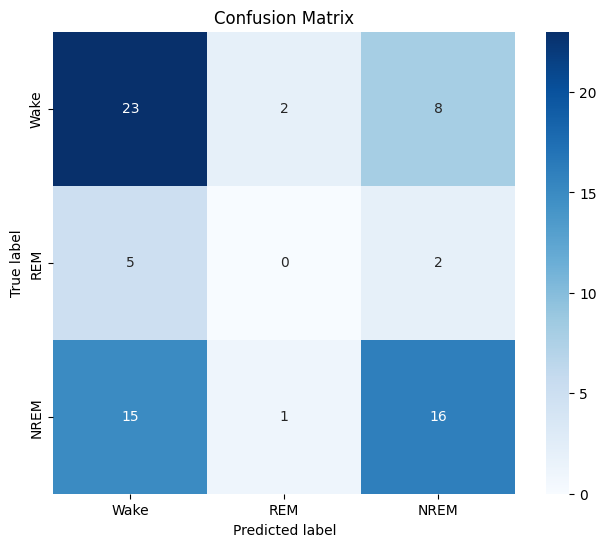

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Generate predictions for the test set
predictions_test = model.predict(segments_test)

# Convert the probabilities to class labels
predicted_labels_test = np.argmax(predictions_test, axis=1)



# Assuming `labels_test` contains the true labels
cm = confusion_matrix(labels_test, predicted_labels_test)


# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', square=True, xticklabels=['Wake', 'REM', 'NREM'], yticklabels=['Wake', 'REM', 'NREM'])
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
